# Neural Networks from Scratch - 02 - From Zero to Hero: The Rocky Neuron Strikes Back!

This tutorial is about hard work, training and perseverance folks, so you better make some coffee and prepare those cookies.

In this tutorial we are going to cover how to train a neural network from scratch.
First let's import the necessary packages

In [26]:
import numpy as np
from typing import Callable, List, Tuple, Set
import matplotlib.pyplot as plt

There should be nothing unsual going on there.
The next cell contains more interesting stuff. 
If you have no idea what's going on there, please look at the [first tutorial](https://github.com/D-K-E/nn-101/blob/master/nn101/01%20-%20A%20Tiny%20Neuron%20is%20Born%20in%20a%20Cookie%20Night.ipynb).
Those are structures defined in the first tutorial. 
They are basically what we'll be training. 

In [42]:
def delta(f,x, h=1e-8): 
    fx_h = f(x+h)
    f_x = f(x)
    diff = fx_h - f_x
    return diff / h

def jacobian(f: Callable[[np.ndarray], np.ndarray], 
                args: np.ndarray, h=1e-8) -> np.ndarray:
    """
    Compute jacobian with numpy
    """
    result = f(args)
    j_mat = np.zeros((*args.shape, *result.shape), dtype=np.float)
    for index in np.ndindex(args.shape):
        narg = args.copy()
        narg[index] += h
        j_mat[index] = (f(narg) - f(args)) / h
    return j_mat.reshape((result.size, args.size))

In [43]:
class AbstractComputation:
    def __init__(self):
        self.args = None
        
    def result(self, arg: np.ndarray):
        raise NotImplemented
        
    def delta(self):
        raise NotImplemented
        
    @property
    def output(self):
        raise NotImplemented
        
    @property
    def d(self):
        raise NotImplemented
        
class Computation(AbstractComputation):
    def __init__(self, inpt=None, function=lambda x: x):
        super().__init__()
        self.args = inpt
        self.f = function
        
    def __str__(self):
        return ("Computation Node:\nInput: " 
                + str(self.args.shape) 
                + "\nOutput:" + str(self.output)
                + "\nFunction" + str(self.f)
               )
    @property
    def output(self):
        return self.compute()
    
    @property
    def d(self):
        return jacobian(f=self.f, args=self.args)
        
    def result(self, arg):
        return self.f(arg)
    
    def compute(self):
        res = self.result(arg=self.args)
        return res.copy()

In [45]:
class Layer(AbstractComputation):
    def __init__(self, flst: List[Callable[[np.ndarray], np.ndarray]], 
                 arg: np.ndarray):
        "Genel hesap katmani (layer)"
        self.args = arg
        self.computations = [Computation(function=f) for f in flst]
        self.is_computed = False
        
    def compute(self):
        previous = self.args.copy()
        current = self.computations[0]
        current.args = previous
        for n in self.computations[1:]:
            n.args = current.output
            current = n
        self.is_computed = True
        
    def compute_until(self, limit: int):
        """
        """
        if limit > len(self.computations):
            raise ValueError(
                "Limit out of bounds for available number of computations " + str(limit)
                + " limit " + str(len(self.computations))
            )
        ns = self.computations[:limit]
        previous_args = self.args.copy()
        current = ns[0]
        current.args = previous_args
        for n in ns[1:]:
            n.args = current.output
            current = n
        return ns
    
    def compute_until_with_arg(self, limit: int, args: np.ndarray):
        """
        """
        if limit > len(self.computations):
            raise ValueError(
                "Limit out of bounds for available number of computations " + str(limit)
                + " limit " + str(len(self.computations))
            )
        ns = self.computations[:limit]
        previous_args = args.copy()
        current = ns[0]
        current.args = previous_args
        for n in ns[1:]:
            n.args = current.output
            current = n
        return ns
    
    def delta_from(self, start: int):
        """
        """
        self.compute()
        if start >= len(self.computations):
            raise ValueError("Start out of bounds " + str(start) +" number of "+
                            " computations: "+ str(len(self.computations)))
        current = self.computations[start]
        current_d = current.d
        for n in self.computations[start+1:]:
            d = n.d
            current_d = np.matmul(d,current_d)
        return current_d
            
    @property
    def output(self):
        self.compute()
        return self.computations[-1].output
    
    @property
    def delta_backwards(self):
        "backward accumulation of derivative"
        self.compute()
        reversed_cs = list(reversed(self.computations))
        last = reversed_cs[0]
        ld = last.d
        for n in reversed_cs[1:]:
            d = n.d
            ld = np.matmul(ld, d)
        return ld
    
    @property
    def delta(self):
        "forward accumulation of derivative"
        return self.delta_from(start=0)

In [46]:
class LinearRegressionLayer(Layer):
    def __init__(self, arg: np.ndarray):
        ""
        self.mx = np.random.randn(*arg.shape)
        self.b = np.zeros_like(self.mx)
        def m_x(x: np.ndarray): return x * self.mx
        def b_x(x: np.ndarray): return x + self.b
        def mx_b(x: np.ndarray): return b_x(m_x(x))
        super().__init__(flst=[m_x, b_x], arg=arg.copy())
        
    @property
    def predict(self):
        """
        y = mx + b = f(x)
        y = f(x)
        mx = M(x)
        +b = B(x)
        f(x) = B(M(x)) = mx + b
        """
        return self.output

## What is Training ? Why bother all the work ?

Now if we are talking about `training` a neural network, a reasonable question is,
what do we mean by training. 
How do you `train` a mathematical structure anyway ??

Let's say you are like me, and thus suck at basketball, so instead of standing outside the 3 pointer field, you enter into it, and instead of facing towards the basket you face towards your friends rooting for you, and upon seeing some random guy breaking into your car, you fling the ball towards car park with all your might.

How would you correct this person ? He surely has his own reasons to behave that way. 
The first thing you would say to this person to correct his mistake would be, throwing the ball towards the basket at all costs, since without that there is no hope of scoring.
Then you would say, in order to score a 3 pointer you need to stand outside of the 3 pointer field. 
Then you would teach him to apply the correct force.

Let's try to formalize this.
Grossly speaking you have about 4 parameters:

- Ball's direction: BD
- Your force: YF
- Your distance to basket: YdB

You also have a single input:

- Ball: b

A 3 pointer, $TP: \mathbb{R}^n \to {0, 1}$, would be something like:$TP(b) = YF(YdB(BD(b)))$.

How do we express formally the notion of correcting the functions that make up the $TP$ ?

One way of doing is to do some random change, and to observe its effect on the output. 
Basically, you say "Face towards the basket, apply a little more force to your arms", then you check whether the person scored or not.
If it did not work, you say "Apply a little more force, and target the square", and then you check again whether the person scored or not.

Basically, you don't change the ball, you don't change the position of the basket, but you try to rearrange parameters that contribute to the functions contituting the $TP$ function.

Now how do you do that with actual mathematical functions ?

We already now how to measure how much the change in the input is reflected in the output thanks to our coverage of derivatives in the [first tutorial](https://github.com/D-K-E/nn-101/blob/master/nn101/01%20-%20A%20Tiny%20Neuron%20is%20Born%20in%20a%20Cookie%20Night.ipynb)

Now we can observe the change, yes, but how do we interpret that change? 
How do we drive the parameters of the functions that compose our $TP$ function towards values that permit us to score a 3 pointer?

Notice that we have two moments to discuss:
- Interpret the change
- Drive the values towards positive change

Roughly speaking the first one is about how far we are from the result we want to achieve, and the second one is about optimizing our existing ressources with respect to a certain goal.

The interpretation of change is done by what statisticians call a `cost` function.
Depending on the context of application having a high cost or a low cost can be interpreted as positive change.

Let's say in our example we want to have the lowest cost possible, that is we want to make sure that the value we compute is as close as possible to our goal.

As per optimization we need to deal with a tiny bit of math to understand how we are going to do it.

So here it is.

TODO: FINISH

$F(X)$ where $X = {x_1, x_2, x_3, \dots, x_n}$, 

$$F: \mathbb{R}^n \to \mathbb{R}^m$$

$$F(x_1) \ge F(x_2) \ge F(x_3) \ge \dots$$

$$X_{n+1} = X_n - \eta \nabla(F(X_n))$$

$$\eta (\lim_{h \to 0} \frac{F(X_n + h) - F(X_n)}{h}) = X_n - X_{n+1}$$



In [48]:
def fn(x): 
    return (x**4) - 3 * (x**3) + 2


some_x = 6.0
step = 0.01
precision = 0.0001

print("value of fn: ", fn(some_x))

# X_{n+1} = X_n - eta * f'(X_n)
for i in range(1000):
    f_x = some_x
    some_x = f_x - step * delta(fn, f_x)
    if abs(some_x - f_x) <= precision:
        break

print("minimum value: ", some_x)
print("last value:", fn(some_x))
print("check value", fn(some_x - 2))

value of fn:  650.0
minimum value:  2.249660012770377
last value: -6.5429675798737
check value 1.9572010269597058


In [152]:
def decrease_derivative(x: float, 
                        f: Callable[[float], float],
                        step=0.01,
                        precision=0.0001,
                        iteration_nb=1000
                       ):
    results = []
    for i in range(iteration_nb):
        f_x = x
        x = f_x - step * delta(f, f_x)
        results.append((x, f(x)))
        if abs(x - f_x) <= precision:
            break
    return results        

In [153]:
def show_results(results):
    arr = np.array(results, dtype=np.float)
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].set_title('input', color="y")
    axes[0].plot(arr[:, 0], "r")
    axes[1].set_title("output", color="y")
    axes[1].plot(arr[:, 1], "g")
    plt.show()

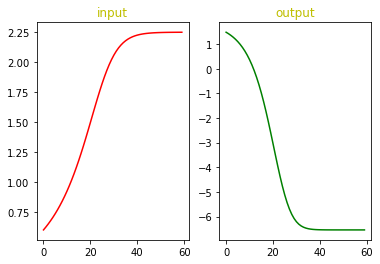

In [154]:
results = decrease_derivative(x=6, f=fn)
show_results(results)

In [180]:
def decrease_derivative_layer(
    inputs: np.ndarray,
    targets: np.ndarray,
    layer: Layer,
    step=0.01,
    precision=0.0001,
    iteration_nb=1000
):
    ""
    ins = inputs.copy()
    outs = targets.copy()
    layer_instance = layer(args=ins, targets=outs)
    ms = []
    bs = []
    outputs = []
    input_s = []
    for i in range(iteration_nb):
        mx = layer_instance.m
        b = layer_instance.b
        layer_delta = layer_instance.delta
        #
        
        layer_d = layer_delta.reshape(*ins.shape)
        new_mx = mx + step * layer_d
        output = layer_instance.output
        new_b = b + step * (layer_instance.targets - output)
        layer_instance.m = new_mx
        layer_instance.b = new_b
        ms.append(mx)
        bs.append(b)
        outputs.append(output)
        input_s.append(layer_instance.computations[-1].args)
        if abs(new_mx.sum()) <= precision:
            break
        elif abs(new_b.sum()) <= precision:
            break
    return layer_instance, np.array(ms), np.array(bs), outputs, input_s

In [181]:
class BinaryProbLayer(Layer):
    def __init__(self, args, targets):
        #self.args = args
        self.targets = targets
        self.m = np.random.uniform(0, 1, size=args.shape)
        self.b = np.random.randn(*targets.shape)
        # f: R^n \to R^m
        # f: mx + b
        # f: b(m(x))
        # f(x) = m * x + b
        super().__init__(flst=[self.score, self.sigmoid, self.cost], arg=args.copy())
    
    def score(self, x: np.ndarray):
        return np.dot(x, self.m.T) + self.b
    
    def cost(self, x: np.ndarray):
        """
        http://ufldl.stanford.edu/tutorial/supervised/LogisticRegression/
        https://en.wikipedia.org/wiki/Cross_entropy
        """
        ins = self.targets.dot(np.log(x))
        others = (1 - self.targets).dot(np.log(1.0 - x))
        return -1 * (ins + others).sum() / others.size 
    
    def sigmoid(self, x):
        return np.exp(x) / (1 + np.exp(x))
    
    def predict(self, x):
        p = self.sigmoid(self.score(x))
        p = np.interp(p, [0.5, 1], [0, 1])
        return 0 if p.max() <= 0.5 else 1

In [182]:
# https://en.wikipedia.org/wiki/Logistic_regression
work_hours = [0.50, 0.75, 1.00,
                 1.25, 1.50, 1.75,
                 1.75, 2.00, 2.25,
                 2.50, 2.75, 3.00,
                 3.25, 3.50, 4.00,
                 4.25, 4.50, 4.75,
                 5.00, 5.50]

exam_result = [0, 0, 0, 
                0, 0, 0,
                1, 0, 1,
                0, 1, 0,
                1, 0, 1,
                1, 1, 1,
                1, 1]

In [183]:
results = (layer, ms, bs, outputs, input_s) = decrease_derivative_layer(
    inputs=np.array([np.array([w]) for w in work_hours], dtype=np.float),
    targets=np.array([np.array(x) for x in exam_result], dtype=np.float),
    layer=BinaryProbLayer,
    step=0.01,
    precision=0.0001,
    iteration_nb=10
)

In [184]:
layer.predict(x=np.array(3.60))

1

In [185]:
def show_train_result(index, results, interval, start):
    fig, axes = plt.subplots(nrows = 2, ncols = 2)
    layer_instance, ms, bs, outputs, input_s = results
    axes[0, 0].set_title("slopes", color="r")
    axes[0, 0].plot(ms[start:start+interval, index], 'r')
    axes[0, 0].set_xticks(range(start, start+interval, 10))
    # intercept
    axes[0, 1].set_title('intercept', color="g")
    axes[0, 1].plot(bs[start:start+interval, index], "g")
    
    # outputs
    axes[1, 0].set_title("outputs", color="y")
    axes[1, 0].set_xticks(range(start, start+interval, 10))
    axes[1, 0].plot(outputs[start:start+interval], "black")
    
    # inputs
    axes[1, 1].set_title("inputs", color="blue")
    axes[1, 1].set_xticks(range(start, start+interval, 10))
    #print(input_s)
    axes[1, 1].plot(input_s[0][start:start+interval, index], "blue")
    plt.tight_layout(True)
    plt.show()
    

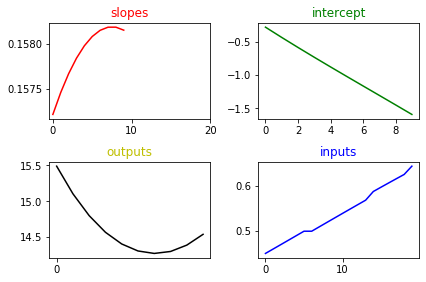

In [186]:
show_train_result(index=0, results=results, interval=30, start=0)